In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [156]:
# Removing Nationality as feature and other unwanted columns from the dataset

df = pd.read_csv("DataSetready.csv")
df_new = df
df_new = df_new.loc[:, 'Continent':'Job']

In [15]:
df["Continent"].unique()

array(['Asia', 'US/Canada', 'EU', 'Other'], dtype=object)

### encoding variables other than categoricals: education and human centerdness(target)
converting Education to ordinal 1 to 5 and changing human centeredness score to ordinal 0 to 2

In [217]:
df_new['Education'].unique()

array(['Secondary school', 'High school', 'Primary school',
       'Undergraduate school', 'Graduate school and higher'], dtype=object)

In [157]:
# Create a mapping of education levels to numerical values
education_mapping = {
    'Secondary school': 1,
    'High school': 2,
    'Primary school': 3,
    'Undergraduate school': 4,
    'Graduate school and higher': 5,
}

# Apply the mapping to create the ordinal column
df_new['Education1'] = df_new['Education'].map(education_mapping)

df_new = df_new.drop(columns=['Education'])
column_to_move = df_new.pop('Education1')
df_new.insert(7,"Education1", column_to_move)

In [35]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Continent   640 non-null    object
 1   Gender      640 non-null    object
 2   Pet         640 non-null    object
 3   Age         640 non-null    int64 
 4   Ethnicity   640 non-null    object
 5   Martial     640 non-null    object
 6   Job         640 non-null    object
 7   Education1  640 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 40.1+ KB


In [158]:
num_intervals = 4

# Automatically set age intervals based on the number of intervals
df_new['Age1'] = pd.cut(df_new['Age'], bins=num_intervals, labels=False, include_lowest=True, right=False)

# Insert 'Age_Category' next to 'Age' column

column_to_move2 = df_new.pop('Age1')
df_new.insert(df_new.columns.get_loc('Age') + 1,"Age1", column_to_move2)
# Display the modified DataFrame
df_new = df_new.drop(columns=['Age'])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Continent   640 non-null    object
 1   Gender      640 non-null    object
 2   Pet         640 non-null    object
 3   Age1        640 non-null    int64 
 4   Ethnicity   640 non-null    object
 5   Martial     640 non-null    object
 6   Job         640 non-null    object
 7   Education1  640 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 40.1+ KB


Following Cell converts human cetredness score to 0 1, and 2 (target variable)

In [159]:
# Create a categorical variable based on equal intervals
df_new['HCC'] = pd.cut(
    df['Human_Centeredness_Score'],
    bins=2,  # Set to the number of desired intervals
    labels=[0, 1],
    right=False
)

In [17]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Continent   640 non-null    object  
 1   Gender      640 non-null    object  
 2   Pet         640 non-null    object  
 3   Age1        640 non-null    int64   
 4   Ethnicity   640 non-null    object  
 5   Martial     640 non-null    object  
 6   Job         640 non-null    object  
 7   Education1  640 non-null    int64   
 8   HCC         640 non-null    category
dtypes: category(1), int64(2), object(6)
memory usage: 40.9+ KB


In [43]:
df_new.to_csv("df_new.csv")

### Defining Features and target values

In [160]:
# Define features (X) and target variable (y)
features = ["Age1","Continent", "Education1", "Pet", "Ethnicity", "Martial", "Job", "Gender"]
#features = ["Age1","Continent", "Education1", "Ethnicity", "Martial", "Gender"]
#X = df_new.loc[:, 'Continent':'Education1'] 
X = df_new[features]
y = df_new['HCC']

In [222]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Age1        640 non-null    int64 
 1   Continent   640 non-null    object
 2   Education1  640 non-null    int64 
 3   Pet         640 non-null    object
 4   Ethnicity   640 non-null    object
 5   Martial     640 non-null    object
 6   Job         640 non-null    object
 7   Gender      640 non-null    object
dtypes: int64(2), object(6)
memory usage: 40.1+ KB


### encoding categorical features by onehot encoding

In [161]:
# Define numerical and categorical columns
numerical_cols = ['Age1', 'Education1']
categorical_cols = X.columns.difference(numerical_cols).tolist()

# Create a new DataFrame without numerical columns
X_categorical = X.drop(columns=numerical_cols)


encoder = OneHotEncoder(sparse=False)

# Fit and transform the categorical DataFrame
X_categorical_encoded = encoder.fit_transform(X_categorical)

# Get the feature names after encoding
feature_names_categorical = encoder.get_feature_names_out(X_categorical.columns)

X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=feature_names_categorical)

X_encoded = pd.concat([X[numerical_cols], X_categorical_encoded_df], axis=1)

In [224]:
X_encoded.to_csv('hotencoded.csv')

### Splitting The dataset to 70 percent train 15 percent test and 15 percent evaluation

In [162]:
# Split the dataset into training (70%) and temporary (30%)
X_train, X_test_eval, y_train, y_test_eval = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# split the test_eval set into eval (15%) and final test (15%)
X_test, X_eval, y_test, y_eval = train_test_split(X_test_eval, y_test_eval, test_size=0.5, random_state=42)

# joining the 15% eval and 70 % train to perform cross-validate

X_trainval = pd.concat([X_train, X_eval], axis=0)

y_trainval = pd.concat([y_train, y_eval], axis=0)

In [121]:
print(y_trainval.shape)
print(X_trainval.shape)
print(X_test.shape)

(544,)
(544, 33)
(96, 33)


### Decision tree model

In [163]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train, y_train)
print("Training set score: {:.3f}".format(tree.score(X_train, y_train)))
print("Test set score: {:.3f}".format(tree.score(X_eval, y_eval)))

Training set score: 0.902
Test set score: 0.552


### Feature importance 

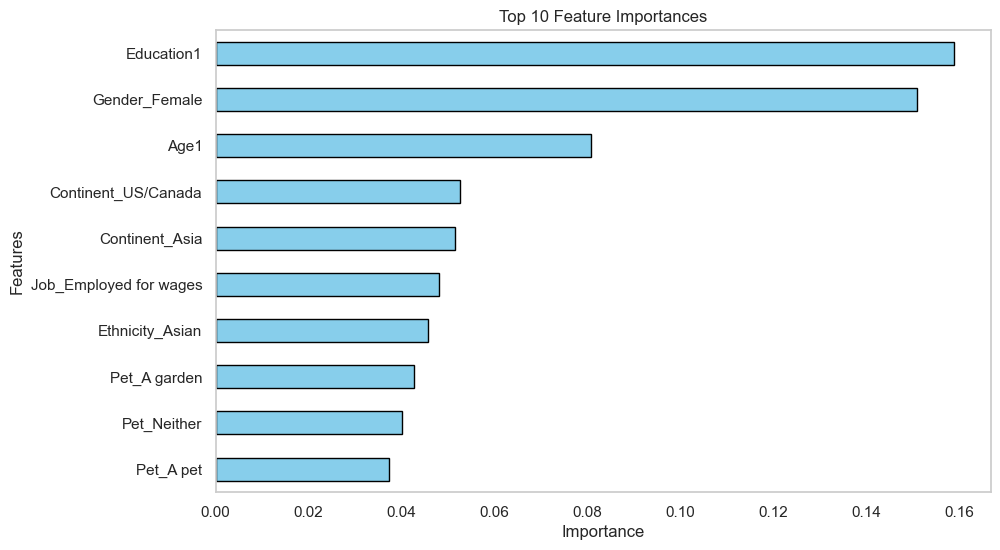

In [98]:
# Create the feature importances series
feat_importances = pd.Series(tree.feature_importances_, index=X_encoded.columns)

# Select the top 10 features with the largest importance
top_features = feat_importances.nlargest(10)

# Sort the values in ascending order for better visualization
top_features = top_features.sort_values(ascending=True)

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='skyblue', edgecolor='black')

# Set chart title and labels
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.grid(False)

In [171]:
importances = tree.feature_importances_
importances

array([0.17788545, 0.08179134, 0.0418759 , 0.01099201, 0.03762824,
       0.06252853, 0.05093638, 0.03314671, 0.02046016, 0.02877134,
       0.00363081, 0.00574174, 0.        , 0.03974593, 0.05754687,
       0.06146169, 0.00724556, 0.03216272, 0.        , 0.05888035,
       0.04023773, 0.0085595 , 0.03031005, 0.03025335, 0.        ,
       0.0552215 , 0.02298613])

### Random Forest Model and evaluation

In [164]:
rf_model = RandomForestClassifier(n_estimators=67, max_depth=3, random_state=42)
rf_model.fit(X_trainval, y_trainval)
print("Training set score: {:.3f}".format(rf_model.score(X_train, y_train)))
print("Test set score: {:.3f}".format(rf_model.score(X_eval, y_eval)))

Training set score: 0.723
Test set score: 0.583


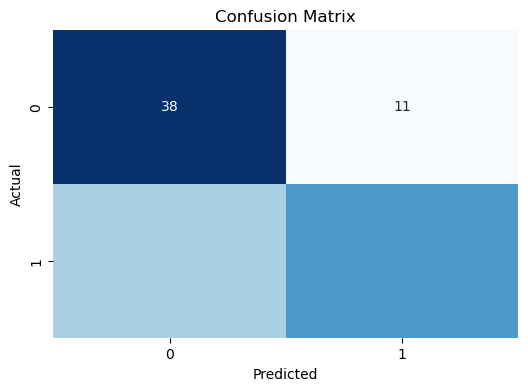

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.78      0.71        49
           1       0.71      0.57      0.64        47

    accuracy                           0.68        96
   macro avg       0.68      0.67      0.67        96
weighted avg       0.68      0.68      0.67        96


In [81]:
# Predictions on the test set
y_pred = rf_model.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

In [153]:
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
rf_auc

0.7401215805471124

### Grid Search and Cross Validation

In [167]:
rf_classifier = RandomForestClassifier(random_state= 42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': list(range(60, 70, 1)),
    'max_depth': list(range(1, 10, 1))
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_trainval, y_trainval)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [168]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 3, 'n_estimators': 67}
Best cross-validation score: 0.686


### Creating Heatmap for the parameters

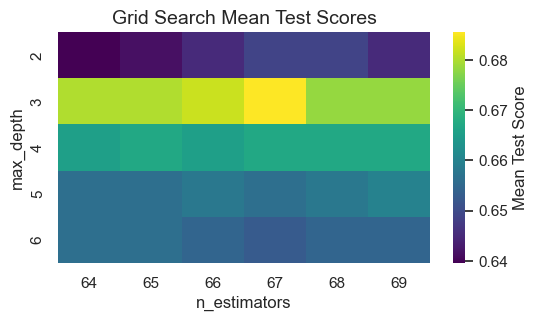

In [139]:
# Extract the results of the grid search
results = pd.DataFrame(grid_search.cv_results_)

# Create a pivot table
pivot_table = results.pivot_table(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(6, 3))
heatmap = sns.heatmap(pivot_table, annot=False, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Score'})
heatmap.set_title('Grid Search Mean Test Scores', fontsize =14 )
heatmap.set_xlabel('n_estimators')
heatmap.set_ylabel('max_depth')
plt.show()

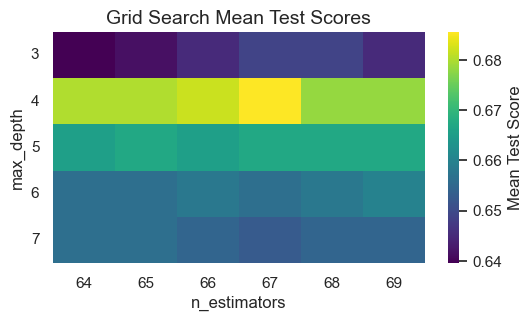

In [154]:
pivot_table = results.pivot_table(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(6, 3))
heatmap = sns.heatmap(pivot_table, annot=False, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Mean Test Score'})

# Adjust the y-axis labels by adding 1
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
heatmap.set_yticklabels([int(label.get_text()) + 1 for label in heatmap.get_yticklabels()])

heatmap.set_title('Grid Search Mean Test Scores', fontsize=14)
heatmap.set_xlabel('n_estimators')
heatmap.set_ylabel('max_depth')

In [78]:
rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=9, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, n_estimators=10, random_state=42)

### Performance on test set

In [79]:
rf_classifier.score(X_test, y_test)

0.6145833333333334

The following function searches for the optimal tree depth in tree based algorithms given algorithm name and list of max_depth. It returns a dataframe containing depth train score and test score.

In [115]:
# Define the max_depth values to iterate over
max_depth_values = [1,2,3,4,5,6,7,8,9,10,11,12,13]

# Initialize an empty DataFrame to store the results
score_df = pd.DataFrame(columns=["max_depth", "train_score", "test_score"])

# Loop over max_depth values
for depth in max_depth_values:
    # Create the random forest model with the specified max_depth
    rf_classifier = RandomForestClassifier(max_depth=depth, n_estimators = 67, random_state=42)
    
    # Train the model
    rf_classifier.fit(X_train, y_train)

    # Make predictions on training and test sets
    train_pred = rf_classifier.predict(X_train)
    test_pred = rf_classifier.predict(X_eval)

    # Calculate accuracy scores
    train_score = accuracy_score(y_train, train_pred)
    test_score = accuracy_score(y_eval, test_pred)

    # Append the results to the DataFrame
    score_df = pd.concat([score_df, pd.DataFrame([[depth, train_score, test_score]], columns=score_df.columns)], ignore_index=True)

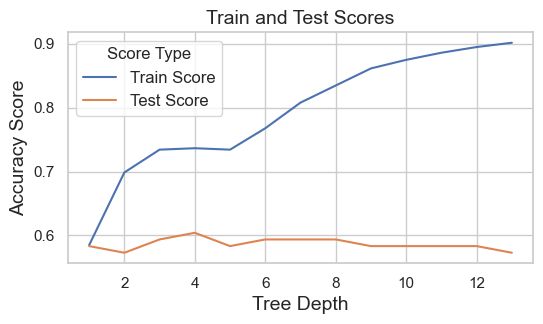

In [112]:
def plot_scores(score_df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 3))

    # Plotting train and test scores with max_depth on the x-axis
    sns.lineplot(data=score_df, x="max_depth", y="train_score", label="Train Score", markers=True)
    sns.lineplot(data=score_df, x="max_depth", y="test_score", label="Test Score", markers=True)

    # Adding labels and title
    plt.title('Train and Test Scores', fontsize=14)
    plt.xlabel('Tree Depth', fontsize=14)
    plt.ylabel('Accuracy Score', fontsize=14)
    plt.legend(title='Score Type', fontsize=12)
    plt.grid(True)

    plt.show()

plot_scores(score_df)

In [152]:
rft_classifier = RandomForestClassifier(n_estimators=74, max_depth=4, random_state=42)
rft_classifier.fit(X_train, y_train)
rft_classifier.score(X_eval, y_eval)

0.6145833333333334